In [ ]:
library(infercnv)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
library(parallel)
library(tryCatchLog)
suppressPackageStartupMessages(library(futile.logger))


In [2]:
get_split_object=function(path, celltype_pred, plasmacells){
obj=readRDS(path)
Idents(obj)=celltype_pred
obj_sub=subset(x = obj, idents = c(plasmacells))
obj_sub$cell_type=obj_sub@meta.data[[celltype_pred]] #Give cell type a common name
obj_list=SplitObject(obj_sub, split.by='orig.ident')
}

In [ ]:
#Load normal cells 
path='/mnt/cnv/LargeData/seurat_obj_nb14_cleanCH.rds'
celltype_pred='bm_pred'
plasmacells="Plasma_cells"

normal_obj_list=get_split_object(path, celltype_pred, plasmacells)

In [2]:
#Load Dara dataset
seuratobj_dara=readRDS("/mnt/MERZ001/LargeData/seuratobj.rds")

In [3]:
#Subset to patient 1 and cancer cells
seuratobj_dara=seuratobj_dara[, seuratobj_dara$patient %in% c("Patient_001")&
                             seuratobj_dara$B_cell_malignant %in% c('malignant')] 

In [4]:
#Load Cart dataset
seuratobj=readRDS('/mnt/MXMERZ002A/LargeData/seuratobj_1.rds')

In [5]:
#Add clonotype_id to Cart dataset
outputfiles=list.files('/mnt/MXMERZ002A/LargeData/enclone/', pattern = 'enclone_B_output', full.names = T)
results_list=bind_rows(lapply(outputfiles, read_csv, show_col_types = FALSE))
seuratobj@meta.data=seuratobj@meta.data %>% rownames_to_column('rownamesbarcode') %>%  mutate(cell_barcode=str_extract(rownamesbarcode, '[ATCG]*-1$')) %>%
select(-b_clonotype_id) %>% 
left_join(results_list %>% select(origins_cell, barcode, b_agg_clonotype_id=group_id), by=c(orig.ident='origins_cell', cell_barcode='barcode')) %>%
column_to_rownames('rownamesbarcode')

In [6]:
#Subset patient 1 and cancer cells
seuratobj_sub=seuratobj[,seuratobj$patient %in% c(1)&
                        seuratobj$b_agg_clonotype_id==1]

In [ ]:
# Merge dara and CART dataset patient 1 together
seuratobj_merged=merge(seuratobj_sub, seuratobj_dara)

In [ ]:
# Add normal cells
obj_process=merge(seuratobj_merged, normal_obj_list[[2]])

In [11]:
# Identify normal cell function
identify_normal_normcell=function(reference1){
non_maglinant_cells=colnames(reference1)[grepl("^normcell", colnames(reference1))]
non_maglinant_cells=na.omit(non_maglinant_cells)
maglinant_cells=colnames(reference1)[!grepl("^normcell", colnames(reference1))]
maglinant_cells=na.omit(maglinant_cells)

    return(list(maglinant=maglinant_cells, normal=non_maglinant_cells))}

In [10]:
get_infercnv=function(reference1, folder, subcluster=NA, pval=NA, groups=NA){

samplename=reference1$patient[1]

sample_annotation_filename=file.path(folder, paste0(samplename, '_sampleannotation.tsv'))

  infercnv_obj=  tryCatchLog(
        expr = {
counts_matrix = GetAssayData(reference1, slot="counts", assay='RNA')

#Make sample annotation file
            
            #################### Identify normal cells function
            cell_types=identify_normal_normcell(reference1)

            #######################
malignant='malignant_plasmacells'
normalcells='normal_plasmacells'           
bind_rows(data.frame(x=cell_types$maglinant, y=malignant), data.frame(x=cell_types$normal, y=normalcells)) %>% write_tsv(sample_annotation_filename, col_names=F)

# create the infercnv object
infercnv_obj = CreateInfercnvObject(raw_counts_matrix=counts_matrix,
                                    annotations_file=sample_annotation_filename,
                                    delim="\t",
                                    gene_order_file="/mnt/MERZ001/Inital_Report/gene_ordering.tsv",
                                    ref_group_names=normalcells)

# perform infercnv operations to reveal cnv signal
infercnv_obj = infercnv::run(infercnv_obj,
                             cutoff=0.1,  # use 1 for smart-seq, 0.1 for 10x-genomics
                          out_dir=file.path(folder,samplename),  # dir is auto-created for storing outputs
                             cluster_by_groups=F,   # cluster
                             denoise=T,
                             num_threads=detectCores(),
                             HMM_type = 'i3',
                             analysis_mode='subclusters',
                             hclust_method='ward.D2',
                             leiden_resolution=pval,
                             tumor_subcluster_partition_method=subcluster,                             
                             HMM=F,                              
                            no_prelim_plot=T,
                             save_rds=T,
                             plot_probabilities=F,
                             plot_steps=F,
                             BayesMaxPNormal=0.5,
                             leiden_function='modularity'                             
                             )

        },
        error = function(e){
            flog.error(paste(samplename, 'encountered error'))
            message('Caught an error!')
            print(e)            
            infercnv_obj=NA

        },
        finally = {
            message('All done')
        }
    )    

return(infercnv_obj)

    }

In [ ]:
flog.threshold(ERROR)  
options(include.full.call.stack = FALSE)   
flog.appender(appender.file("infercnv_combined_modularity_0.5_continuefromstep15.log"))
folder='/mnt/MXMERZ002A/LargeData/infercnv/combined_modularity_0.5'
dir.create(folder, recursive=T)
infercnv_results=mclapply(normal_obj_list_process, get_infercnv, pval=0.5,  subcluster='leiden', folder=folder, mc.cores=detectCores())

In [13]:
plotcnvs=function(sample_i){
infercnv_obj_path=file.path(result_folder, sample_i, 'run.final.infercnv_obj')
print(infercnv_obj_path)
infercnv_obj=readRDS(infercnv_obj_path)

cellnames=colnames(infercnv_obj@expr.data)
infercnv_obj@observation_grouped_cell_indices=infercnv_obj@tumor_subclusters$subclusters$all_observations

infercnv_obj@tumor_subclusters=NULL
    
title_string=sample_i
plotoutput=plot_cnv(infercnv_obj, cluster_by_groups = T, title=paste(title_string, sample_i, sep='-'),  out_dir=out_dir, output_filename=sample_i, output_format = 'png')
}

In [8]:
# Plot results
sample_is=c('1')
result_folder='/mnt/MXMERZ002A/LargeData/infercnv/combined_modularity_0.5/'
out_dir=file.path(result_folder, 'heatmaps_leidencluster')
dir.create(out_dir, recursive=T)
plotcnvresult=lapply(sample_is, plotcnvs)
# More CNV clusters observed for Dara+CART combined but these clusters correspond to those in Dara-only data. 

In [7]:
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ComplexHeatmap))

In [8]:
# Function to find bands corresponding to CNV hit ranges
find_bands=function(cinnie_grange){

overlap_hit=findOverlaps(cinnie_grange, cytoband_grange)
overlaps <- pintersect(cinnie_grange[queryHits(overlap_hit)], cytoband_grange[subjectHits(overlap_hit)])
overlaps_df=as.data.frame(cinnie_grange[queryHits(overlap_hit)]) %>% unite(range, seqnames, start, sep=":", remove=F) %>% unite(range, range, end, sep="-", remove=F) %>% select(range:end,range, id, orig.ident, state, prob)
overlaps_df$percentOverlap <- width(overlaps) / width(cytoband_grange[subjectHits(overlap_hit)]) > 0.5
overlaps_df$band=cytoband_grange$band[subjectHits(overlap_hit)]
overlaps_df=overlaps_df[overlaps_df$percentOverlap,] #Keep only those with 0.5 overlap

overlaps_df$percentOverlap=as.integer(overlaps_df$percentOverlap) #Convert to integer to calculate jaccard later on

overlaps_df=overlaps_df %>% arrange(seqnames, start)

    return(overlaps_df)
}

In [9]:
#Make cytoband grange
cytoband=read_tsv('/mnt/cnv/LargeData/cytoBand.txt', col_names = c('chr','start','end','band','stain'), show_col_types = FALSE)
cytoband=cytoband %>% filter(!grepl('^chr.{1,2}_',chr)) %>% mutate(chr=gsub('chr','',chr), chr2=chr) %>% unite("band",chr2, band, sep="") #chromosome number to band
cytoband_grange=makeGRangesFromDataFrame(cytoband %>% select(chr:band), keep.extra.columns = T)

In [3]:
# Get CNV region with probabilities
gather_results3=function(result_path){
    
tabulate_results=function(i){
samples_path=file.path(result_path, i)

cnv_regions_dat=read_tsv(file.path(samples_path, 'HMM_CNV_predictions.HMMi3.hmm_mode-samples.Pnorm_0.5.pred_cnv_regions.dat'), show_col_types = FALSE)
    

MCMC_inferCNV_obj=readRDS(file.path(samples_path, 'BayesNetOutput.HMMi3.hmm_mode-samples/MCMC_inferCNV_obj.rds'))
max_prob=map(MCMC_inferCNV_obj@cnv_probabilities[MCMC_inferCNV_obj@cnv_regions %in% cnv_regions_dat$cnv_name], ~max(apply(.x,2,median)))
cnv_regions_dat$prob=unlist(max_prob)

status_ind=c('Loss','Neutral','Gain')
cnv_regions_dat$state=status_ind[cnv_regions_dat$state]
cnv_regions_dat=cnv_regions_dat %>% select(-cnv_name) %>% 
group_by(cell_group_name) %>%  mutate(id=paste0(i, '_cluster_', cur_group_id()), .before=state) %>% 
ungroup %>% select(-cell_group_name)}
    
samples=list.dirs(result_path, full.names=F, recursive=F)
    samples=samples[!grepl("^\\.|heatmaps", samples)]
table_results_=map(samples, tabulate_results)

table_results=bind_rows(table_results_)

table_results=table_results %>% filter(state!='Neutral') %>% filter(chr!=23)
#table_results=table_results %>% filter(state=='Loss') %>%  arrange(-prob)  %>% distinct(chr, end, .keep_all = T) %>% slice_head(n=10)
    return(table_results)

}

In [4]:
# Plot CNV results from Dara-only data
patient1_redo_results=gather_results3('/mnt/MERZ001/Inital_Report/infercnv/redo_patient_1_1319')
patient1_redo_results=patient1_redo_results %>% mutate(id=gsub("_cluster_1$", "", id)) %>% mutate(id=gsub("(\\d)$", "_\\1", id))

In [18]:
#Plot continuous, with cross cluster consideration
table_cinnie_=patient1_redo_results
table_cinnie_=table_cinnie_ %>% mutate(orig.ident=str_match(.$id, "(.*)_cluster_\\d")[,2])
cinnie_grange=makeGRangesFromDataFrame(table_cinnie_, keep.extra.columns=T)

bands_concat=find_bands(cinnie_grange)
bands_concat=bands_concat %>% mutate(state=ifelse(state=='Gain',1,-1)) %>% mutate(prob=prob*state)
bands_concat=bands_concat %>% mutate(seqnames=as.integer(as.character(seqnames))) %>%arrange(seqnames, start)

In [19]:
bands_concat=bands_concat %>% group_by(orig.ident, state, band) %>% 
mutate(gain_check=max(prob)>0.95 & prob>0.8) %>%
 mutate(loss_check=min(prob)< -0.95 & prob< -0.8)
bands_concat_continuous=bands_concat %>% mutate(prob=ifelse(gain_check|loss_check, prob, NA))

bands_df_widened=bands_concat_continuous %>% pivot_wider(id_cols=id, names_from=band, values_from=prob, values_fill=NA) %>%
                arrange(id)
mat_for_jaccard=as.matrix(bands_df_widened %>% select(-id))
rownames(mat_for_jaccard)=bands_df_widened$id


band_annot=str_extract(colnames(mat_for_jaccard), "^\\d{1,2}(p|q)")
band_annot=factor(band_annot, levels=unique(band_annot))

patient_annot=str_extract(rownames(mat_for_jaccard), "Patient_0\\d*")


col_fun_plot = colorRamp2(c(-1, 0, 1), c("blue", "white","red"))

mat_for_jaccard_continuous=mat_for_jaccard

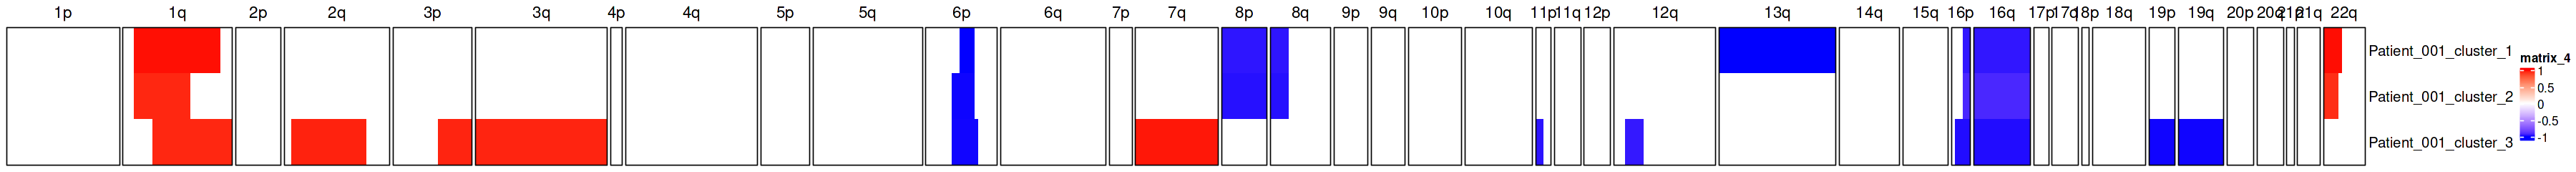

In [23]:
options(repr.plot.width = 30, repr.plot.height =2)
band_annot=str_extract(colnames(mat_for_jaccard), "^\\d{1,2}(p|q)")
band_annot=factor(band_annot, levels=unique(band_annot))
levels(band_annot)=str_sort(levels(band_annot), numeric = T)
Heatmap(mat_for_jaccard_continuous, cluster_columns=F, cluster_rows=F, 
        show_row_names=T,show_column_names=F, 
        column_split=band_annot, 
        cluster_row_slices =F, cluster_column_slices=F, col=col_fun_plot,
        na_col = "white",border = TRUE)

In [ ]:
# Generate Sankey plot

In [34]:
plotalluvial=function(clone_counts_plot_long, facet_spacing=2, rotate=F, xaes='origins_cell', title=NA) {
    xaes=sym(xaes)
    if (is.na(title)){
        title=paste("Patient",clone_counts_plot_long$donors[1])
    }
    p=ggplot(clone_counts_plot_long,
       aes(x = !!xaes, stratum = group_id, alluvium = group_id,
           y = value,
           fill = group_id, label = group_id)) +
  scale_x_discrete(expand = c(.1, .1)) +
  geom_flow() +
  geom_stratum(alpha = .5) +
  #geom_text(stat = "stratum", size = 3) +
  #guides(fill="none")+
    guides(fill=guide_legend(title="CNV clones"))+
    facet_wrap(~freq, scales="free_y")+
  ggtitle(title) +
    #scale_fill_manual(values = DiscretePalette(levels(clone_counts_plot_long$group_id))) +
 scale_color_manual(breaks =c('CMV', 'EBV'), values=c("#ff0000","#ff0000", "#ff0000"), na.value	 = "#000000")+
 ylab("")+
    theme(text = element_text(size = 18))  +xlab("")+ theme(plot.margin = margin(t = 0, r = 2, b = 0, l = 0, "cm"),
                                                           legend.position=c(.4,.75))+ 
    theme(panel.spacing = unit(facet_spacing, "lines"))
    if (rotate){
    p=p+ theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
    }
    return(p)
}

In [19]:
get_cnv_clusters=function(result_folder, sample_i){
infercnv_obj_path=file.path(result_folder, sample_i, 'run.final.infercnv_obj')
infercnv_obj=readRDS(infercnv_obj_path)
obs_list=infercnv_obj@tumor_subclusters$subclusters$all_observations
a=bind_rows(lapply(seq_along(obs_list), function(i) {data.frame(barcode=names(obs_list[[i]]), cnv_cluster=i , patient=sample_i, 
                                                                date=projects_metadata[names(obs_list[[i]]), 'collection.day'],
                                                                source=projects_metadata[names(obs_list[[i]]), 'source'],
                                                                batch=projects_metadata[names(obs_list[[i]]), 'Batch']
                                                               )}))
   
    
}

In [16]:
# Dara dataset
#Pseudo seuratobj
metadata_dara=readRDS('/mnt/MERZ001/LargeData/seuratobj.metadata.rds')
seuratgen_dara=setClass("seurat", slots=list(meta.data="data.frame"))
seuratgen_dara=seuratgen_dara(meta.data=metadata_dara)

project1_metadata=seuratgen_dara@meta.data %>% 
select(orig.ident, source=CellType, patient, collection.day=date.of.sample.acquisition) %>% 
mutate(Batch=1) %>% mutate(source=ifelse(source=='PBMC', 'PB', 'BM')) %>% mutate(patient=as.integer(str_match(patient, 'Patient_0+(\\d+)')[,2]))

cnv_clusters_full_celllevel=readRDS('/mnt/MERZ001/Inital_Report/cnv_clusters_full_celllevel.rds')

#Take only clonotyped cells
cnv_clusters_full_celllevel=cnv_clusters_full_celllevel %>% 
left_join(seuratgen_dara@meta.data %>% rownames_to_column('barcode') %>% select(source=CellType, barcode, B_cell_malignant), by='barcode') %>%
filter(B_cell_malignant=='malignant') %>% mutate(source=ifelse(source=='PBMC', 'PB', 'BM')) %>% 
mutate(patient=str_match(patient, 'Patient_0+(\\d+)')[,2])

In [17]:
# CART dataset
metadata_excel=read.xlsx('/mnt/MXMERZ002A/LargeData/metadata.xlsx', sheetName='Sheet2')
metadata_excel=metadata_excel %>% select(barcode, collection.day) 
project2_metadata=read_csv('/mnt/MXMERZ002A/LargeData/seuratobjmetadata.csv', show_col_types = FALSE)
project2_metadata=project2_metadata %>% select(cellbarcode, orig.ident, barcode, source, patient) 
project2_metadata=project2_metadata %>% left_join(metadata_excel, by = "barcode") %>% 
mutate(collection.day=as.character(collection.day)) %>% mutate(Batch=2)
project2_metadata=column_to_rownames(project2_metadata, 'cellbarcode') %>% mutate(Batch=2)

In [18]:
projects_metadata=bind_rows(project1_metadata, project2_metadata %>% select(!barcode))

In [25]:
p1results=get_cnv_clusters('/mnt/MXMERZ002A/LargeData/infercnv/combined_modularity_0.5/', '1')

In [26]:
p1results=p1results %>% mutate(cnv_cluster2=ifelse(cnv_cluster %in% c(1, 3, 7, 8), 2, NA)) %>%
mutate(cnv_cluster2=ifelse(cnv_cluster %in% c(2, 4, 5, 9), 1, cnv_cluster2)) %>%
mutate(cnv_cluster2=ifelse(cnv_cluster ==6, 3, cnv_cluster2)) %>%
mutate(cnv_cluster=cnv_cluster2) %>%
select(!cnv_cluster2)

In [28]:
cnv_clusters_full_celllevel_combined=p1results

In [29]:
# Sum up and calculate percentages
cnv_clusters_full=cnv_clusters_full_celllevel_combined %>% count(cnv_cluster, date, patient, source, batch, name='count')
cnv_clusters_full=cnv_clusters_full %>% group_by(date, patient, source) %>% mutate(total=sum(count)) %>% mutate(percentage=count/total*100)
cnv_clusters_full_long=cnv_clusters_full %>% pivot_longer(c(count, percentage), names_to='freq')  %>%
unite(day_source, date, source) %>% rename(donors='patient', group_id='cnv_cluster') %>% mutate(group_id=as.character(group_id))


In [30]:
cnv_clusters_patient=cnv_clusters_full_long 

Here we check the change in size of the CNV sub clones among the malignant cells over time for patient 1. Each CNV sub clone is defined by its CNV profile as shown in 10.infercnv.ipynb. 

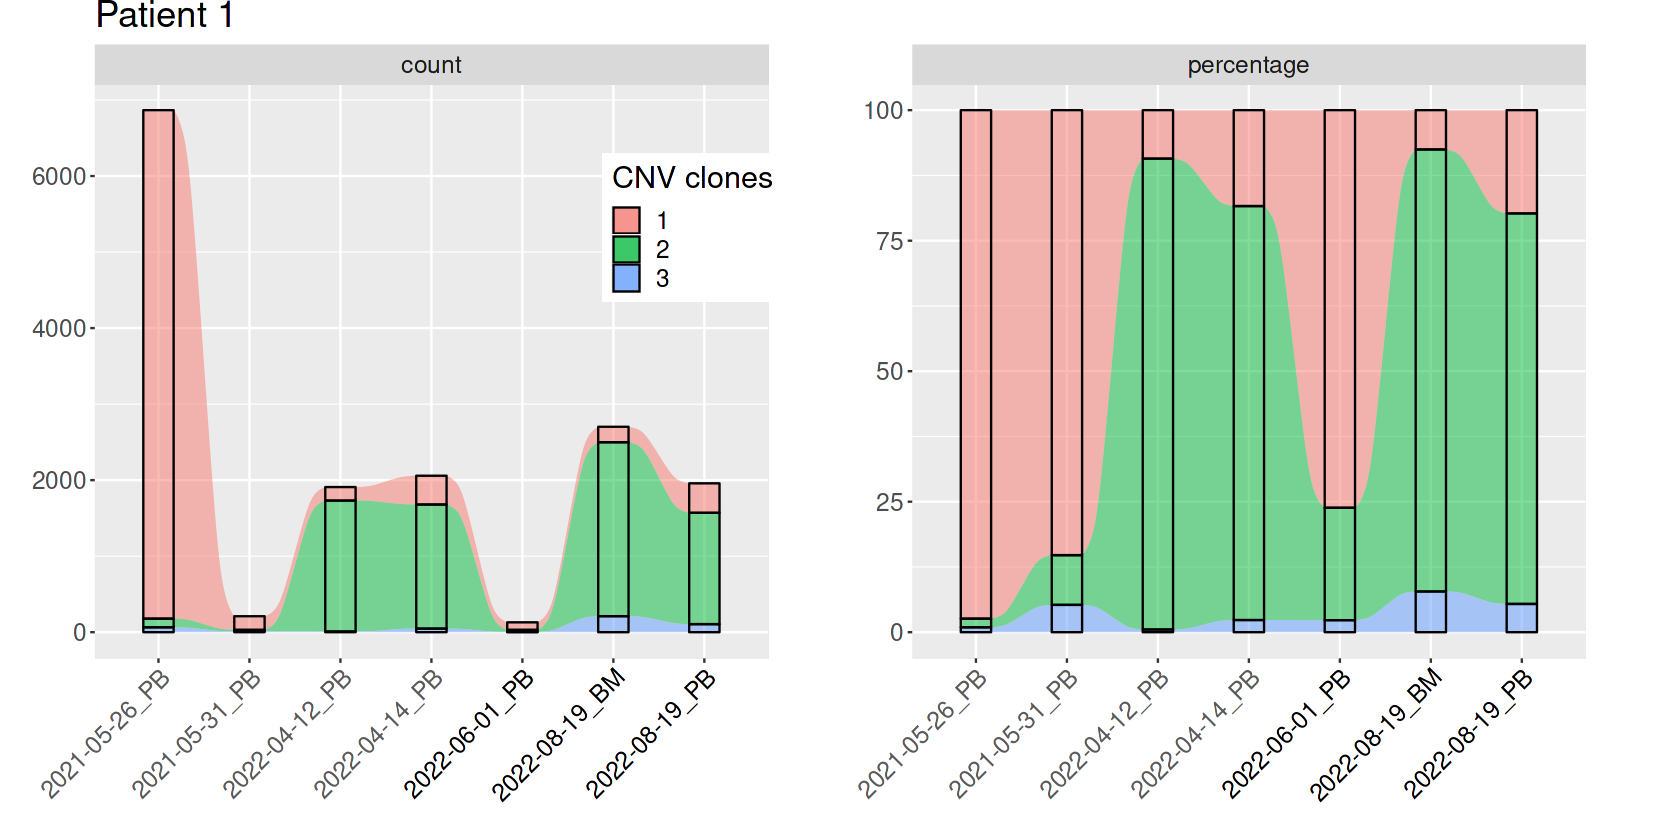

In [35]:
# Figure 8D
options(repr.plot.width=14, repr.plot.height=7, warn=-1)
batchno=cnv_clusters_patient %>% select(day_source, batch) %>% distinct %>% arrange(day_source) %>% select(batch) %>% unlist
bold.labels <- ifelse(batchno == 2, yes = "black", no = "#5A5A5A")
plotalluvial(cnv_clusters_patient, xaes='day_source', facet_spacing=4, rotate=T)+
  theme(axis.text.x = element_text(color = bold.labels)) 
options(warn=0)